In [726]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Lab 6 - Fisher's Linear Discriminant and Logistic Regression
- For equations, refer to Bishop's book, Section 4.1.4 and the slides

 # Part I - Fisher's Linear Discriminant for Binary Classification (2 classes)

## Data Generation and Visualisation
- First we'll use scikit-learn to generate 2 blobs of data in 2D, using the [make_blobs()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function.
- The data consists of 600 points divided into 2 classes, 0 and 1.

In [727]:
from sklearn.datasets import make_blobs

In [728]:
X, y = make_blobs(n_samples=600, centers=2, n_features=2, random_state=0)

Let's confirm the data has two classes

In [729]:
np.unique(y)

array([0, 1])

## Exercise 1
- Now create a scatter plot to visualise the generated data. 
- Make sure to paint each point based on the class they belong to, as shown in the Figure below.

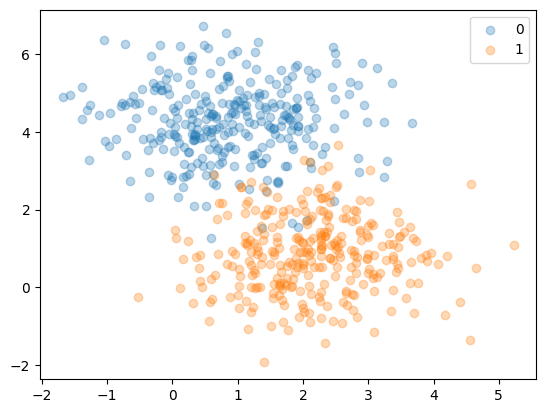

In [730]:
def plotPoints(X, y):
    for label in np.unique(y):
        Xlabel = X[y==label]
        plt.scatter(
            Xlabel[:,0],
            Xlabel[:,1], 
            colorizer=True, 
            alpha=0.3,
            label=label)
        

plotPoints(X,y)

plt.legend()
plt.show()

## Exercise 2
* Now plot a histogram of the data projected on each of the 2 dimensions of $X$ ($0$ and $1$)

As an example, below is a figure that shows the projection on dimension $1$.

_Tips:_ 
* You can either use `histplot()` to generate the plot, in which case it might be easier to pack $X$ and $y$ into a pandas DataFrame.
* Alternatively, considering that you will generate this plot many times throughout this lab, you can write a function that takes the projected vector and the class labels.
* Use 30 bins to obtain a similar plot.

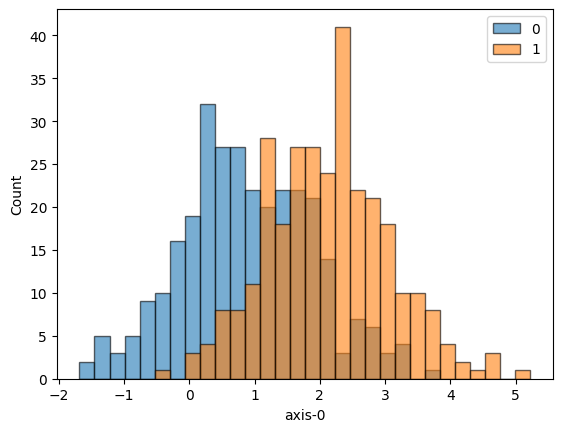

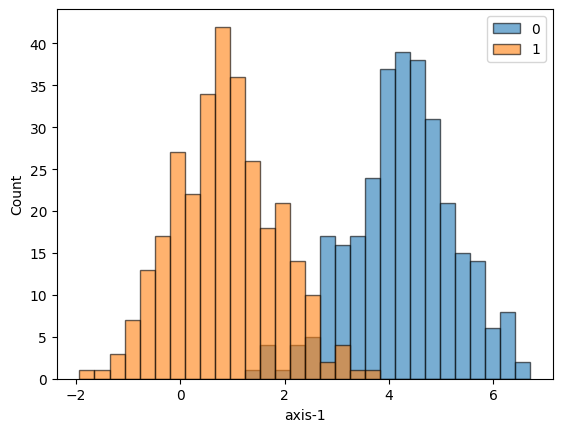

In [731]:

def plotVec(proVec, yLabels):
    bin_edges = np.histogram(proVec, bins=30)[1] # getting the width of the bars (*BEAUTY*)
    for label in np.unique(yLabels):
        plt.hist(
            proVec[yLabels==label],
            bins=bin_edges,
            edgecolor='black',
            alpha=0.6,
            label=label
            )
    
    
for axis in range(2):
    projec=X[:,axis]
    plotVec(projec,y)
    plt.xlabel(f"axis-{axis}")
    plt.ylabel('Count')
    plt.legend()
    plt.show()
proVec1 = X[:,0]
proVec2 = X[:,1]


## Exercise 3 - Implement Fisher's linear discriminant

* Use numpy to calculate $\vec{w}$.
* Plot the data (as you did in Exercise 1), and add a line on the direction of $\vec{w}$ (reference Figure below).
* Project the points onto the calculated vector, and plot the projection (as you did in Exercise 2) (reference Figure below).

In [732]:
def fisherLinearDiscriminant(X, y):
    X0 = X[y==0]
    X1 = X[y==1]
    m0 = np.array([0,0], dtype='float64')
    for point in X0:
        m0+=point

    m1 = np.array([0,0], dtype='float64')
    for point in X1:
        m1+=point

    m0 /= X0.shape[0]
    m1 /= X1.shape[0]

    Sw = np.zeros((X.shape[1], X.shape[1]), dtype='float64')
    for point in X0:
        diff = (point - m0).reshape(-1, 1)
        Sw += diff @ diff.T

    for point in X1:
        diff = (point - m1).reshape(-1, 1)
        Sw += diff @ diff.T
        
    w = np.linalg.inv(Sw) @ (m1 - m0)
    return w
    

w = fisherLinearDiscriminant(X,y)


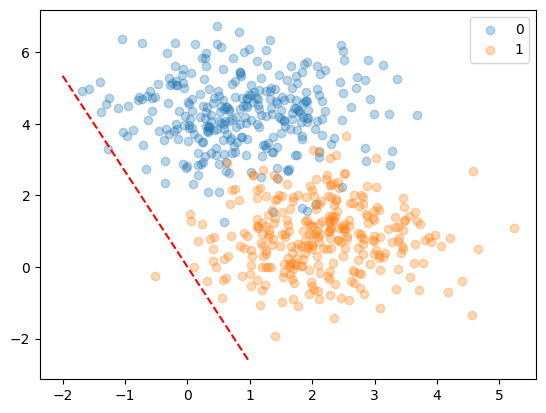

In [733]:
def plot_w_Line(v, num_points=10):
    v *= 1/v[0]
    t = np.linspace(-2,1,num_points)
    x = t * v[0]
    y = t * v[1]
    plt.plot(x,y,'--', color='red')
    

plotPoints(X,y)
plot_w_Line(w)
plt.xticks(np.arange(-2,6,1))
plt.legend()
plt.show()


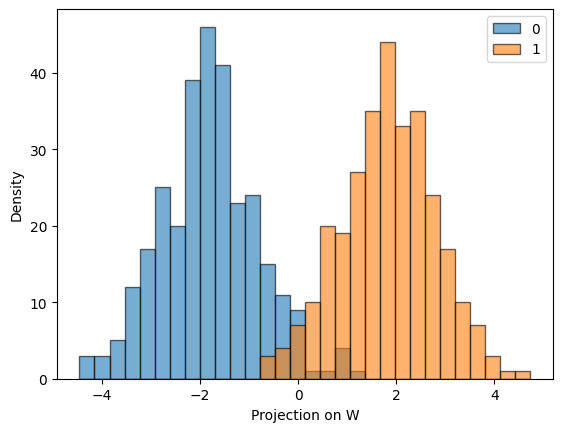

In [734]:
def projec_w(w, X, y):
    X0 = X[y==0]
    X1 = X[y==1]
    m0 = np.mean(X0, axis=0)
    m1 = np.mean(X1, axis=0)
    center = (m0 + m1) / 2

    w_proj_vecs = ((X @ w) / (w.T @ w))[:, np.newaxis] * w  # Shape: (n, 2)

    center_proj = (center @ w) / (w.T @ w) * w
    distances = np.linalg.norm(w_proj_vecs - center_proj, axis=1)
    signs=np.sign((X @ w) - (center @ w))
    l_proj_vecs = signs * distances
    plotVec(np.array(l_proj_vecs), y)
    plt.legend()
    plt.xlabel("Projection on W")
    plt.ylabel('Density')

    return l_proj_vecs


project_vecs_w = projec_w(w, X, y)

    


## Exercise 4

* In this exercise you will use the `RidgeClassifier` from sklearn (as shown below) to obtain the class predictions from different types of projections:
    * component 0 of the data
    * component 1 of the data
    * the calculated vector $\vec{w}$
    
* Calculate the accuracy of these predictions using `accuracy_score` from sklearn.

In [735]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier

In [736]:
r = RidgeClassifier()
r.fit(proVec1.reshape(-1,1), y)
predicted_y = r.predict(proVec1.reshape(-1,1))
accuracy1 = accuracy_score(predicted_y, y)


In [737]:
r.fit(proVec2.reshape(-1,1), y)
predicted_y = r.predict(proVec2.reshape(-1,1))
accuracy2 = accuracy_score(predicted_y, y)

In [738]:
r.fit(project_vecs_w.reshape(-1,1), y)
predicted_y = r.predict(project_vecs_w.reshape(-1,1))
accuracyFisher = accuracy_score(predicted_y, y)

print(f"projection: first dimension, accuracy = {accuracy1}")
print(f"projection: second dimension, accuracy = {accuracy2}")
print(f"projection: Fisher's linear discriminant, accuracy = {accuracyFisher}")

projection: first dimension, accuracy = 0.7366666666666667
projection: second dimension, accuracy = 0.955
projection: Fisher's linear discriminant, accuracy = 0.965


# Part II - Generalised Linear Discriminant (multi-class)

**NOTE:** For this part you will be using a multi-class estimator from scikit-learn (read the [documentation](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)).

## Exercise 1 - Generate data

* Generate a 3 classes dataset in 2D, with the same rules as before (make 300 points per class)
* Plot the data and then similar histograms (on each dimension) as Part I Exercises 1 and 2.

In [739]:
# your code goes here: 
X, y = make_blobs(n_samples=300*3, centers=3, n_features=2, random_state=0)

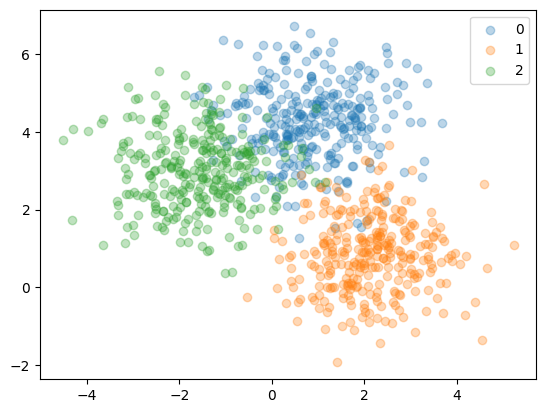

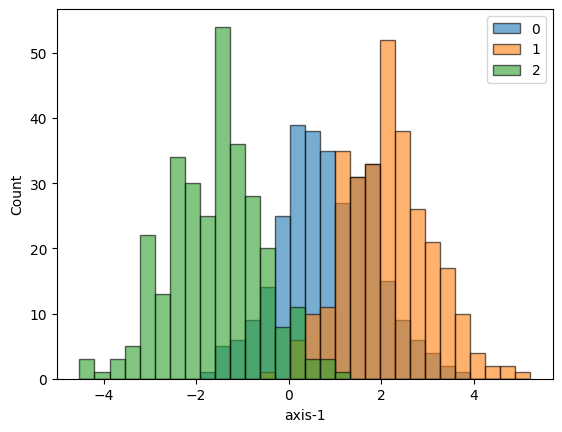

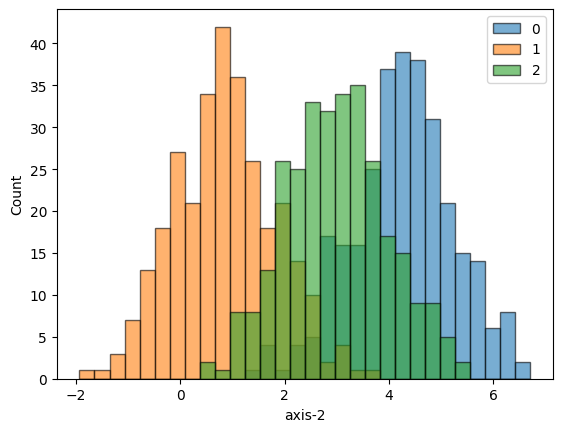

In [740]:
# your code goes here:
plotPoints(X,y)
plt.legend()
plt.show()

for axis in range(2):
    projec=X[:,axis]
    plotVec(projec,y)
    plt.legend()
    plt.xlabel(f"axis-{axis + 1}")
    plt.ylabel("Count")
    plt.show()


## Exercise 2 - Linear Discriminant Analysis

* Use sklearn's implementation of LDA to project the points in a single dimension and then plot the projected data

In [741]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Remember that since we want to project our data onto a vector, the parameter n_components of `LinearDiscriminantAnalysis` should be set to 1

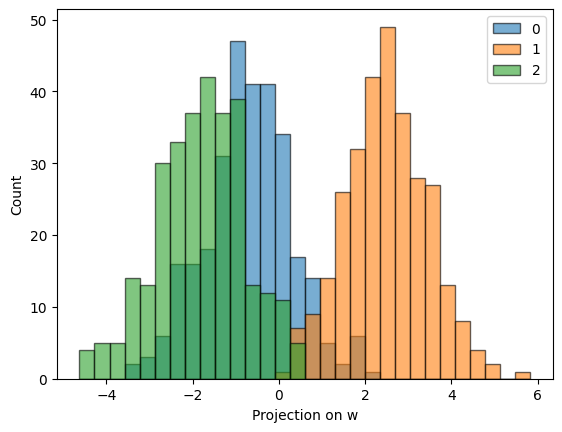

In [742]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_clf = lda.fit_transform(X,y)

plotVec(X_clf, y)
plt.legend()
plt.xlabel("Projection on w")
plt.ylabel("Count")
plt.show()



## Exercise 3 - Calculate test set accuracy

* use the default parameters for the LDA classifier, and report the prediction accuracy on a train/test split of 70/30% (use `random_state=0`)
* report also the accuracy of the `RidgeClassfier` you used in Part I 

In [743]:
from sklearn.model_selection import train_test_split

In [744]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
lda.fit(X_train, y_train)
lda_score = lda.score(X_test,y_test)

r = RidgeClassifier()
r.fit(X_train, y_train)
predicted_y = r.predict(X_test)
r_score = accuracy_score(predicted_y, y_test)

print("Test Accuracies:")
print(f"LDA classifier: {lda_score}")
print(f"Ridge Classifier fitting: {r_score}")


Test Accuracies:
LDA classifier: 0.937037037037037
Ridge Classifier fitting: 0.9259259259259259


# Part III - Logistic Regression for Binary Classification

## Exercise 1 - Load the dataset

* Load the diabetes dataset (`diabetes.csv`)
* Make a 70/30% train test partition of the dataset

*Suggestion:* I suggest you load it with pandas, but make a scikit-learn style dataset ($X$, $y$ numpy arrays)

In [745]:
# your code goes here:
df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1).to_numpy()
y = df['Outcome'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

## Excercise 2 - Implementing Logistic Regression

* In this exercise you will implement the logistic regression algorithm to learn the vector of weights $\vec{w}$.
* You will then plot the ROC curve (using your implementation from the Tarefa), and calculate the AUROC (Area Under the ROC curve) using `sklearn.metrics.roc_auc_score()` for the testing set.

You can follow the structure for gradient descent as described in the previous labs and slides. Don't forget to write a function that calculates the sigmoid. You are not allowed in this exercise to use any existing functions.
* **Note that:** in the book and slides `y` is written as `t` and `y_hat` as `y`. 

Remember that $\nabla E(w) = \sum_{n=1}^N (y_n - t_n)\phi_n$ 

* _Tip:_ plot the loss during training to verify that everything is working properly.

In [746]:
# your code goes here:
from math import *

def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow


def logisticRegression(X, y, step=1e-3,max_iter=10000):
    X = (X - X.mean()) / X.std() # Normalizing the Matriz
    X_bias = np.c_[np.ones(X.shape[0]), X] # Adding the bias to the matrix
    w = np.zeros(X_bias.shape[1])
    
    for iteration in range(max_iter):
        y_pred = sigmoid(X_bias @ w)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # Avoid log(0)
        
        gradE = (y_pred - y) @ X_bias

        w = w - step*gradE

        error = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        print(f"Iteration {iteration + 1}, Loss: {error}")

    return w,error
    
def predictLogisticRegression(X, w):
    X_bias = np.c_[np.ones(X_test.shape[0]), X]
    X_bias = (X_bias - X_bias.mean()) / X_bias.std() # Normalizing the Matriz

    y_predicted_c1 = sigmoid(X_bias @ w)
    y_predicted = np.array([[1 - pc1, pc1] for pc1 in y_predicted_c1])

    return y_predicted

w, e = logisticRegression(X_train, y_train,step=3e-3, max_iter=1000)
print(e)


Iteration 1, Loss: 372.2200359606906
Iteration 2, Loss: 351.97833981741746
Iteration 3, Loss: 345.8510220645254
Iteration 4, Loss: 340.8275750848986
Iteration 5, Loss: 337.97688581948444
Iteration 6, Loss: 334.5610228142128
Iteration 7, Loss: 333.34279696246546
Iteration 8, Loss: 329.6151524113272
Iteration 9, Loss: 328.52896137711423
Iteration 10, Loss: 323.8306274202048
Iteration 11, Loss: 322.55914786348194
Iteration 12, Loss: 317.37185350458003
Iteration 13, Loss: 316.107016937911
Iteration 14, Loss: 310.9954139591342
Iteration 15, Loss: 309.8579720123346
Iteration 16, Loss: 305.1386801157645
Iteration 17, Loss: 304.13993837794305
Iteration 18, Loss: 299.94100079227735
Iteration 19, Loss: 299.05049918979006
Iteration 20, Loss: 295.3997229111069
Iteration 21, Loss: 294.58339636861604
Iteration 22, Loss: 291.46003426465467
Iteration 23, Loss: 290.69293185716356
Iteration 24, Loss: 288.0538926493502
Iteration 25, Loss: 287.32198135115425
Iteration 26, Loss: 285.11515805945135
Iteratio

Evaluate the performance of your model, plot the ROC curve and calculate the AUROC

In [747]:
from sklearn.metrics import roc_auc_score

In [748]:
def get_fpr_tpr(predicted_values, true_labels):
    thresholds = []
    fprList = []
    tprList = []
    for threshold in predicted_values[:,1]:
        thresholds.append(threshold)
    thresholds.sort()
    for threshold in thresholds:
        fp = 0
        tp = 0
        tn = 0
        fn = 0
        for idx, result in enumerate(predicted_values): # for each result in the list
            pProb = result[1] # we get the positive probability
            
            if pProb >= threshold: # 1
                if true_labels[idx] == 1:
                    tp += 1
                else:
                    fp += 1
            else: # 0
                if true_labels[idx] == 1:
                    fn += 1
                else:
                    tn += 1
            
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        fprList.append(fpr)
        tprList.append(tpr)

    
    return fprList, tprList


Iteration 1, Loss: 372.2200359606906
Iteration 2, Loss: 351.97833981741746
Iteration 3, Loss: 345.8510220645254
Iteration 4, Loss: 340.8275750848986
Iteration 5, Loss: 337.97688581948444
Iteration 6, Loss: 334.5610228142128
Iteration 7, Loss: 333.34279696246546
Iteration 8, Loss: 329.6151524113272
Iteration 9, Loss: 328.52896137711423
Iteration 10, Loss: 323.8306274202048
Iteration 11, Loss: 322.55914786348194
Iteration 12, Loss: 317.37185350458003
Iteration 13, Loss: 316.107016937911
Iteration 14, Loss: 310.9954139591342
Iteration 15, Loss: 309.8579720123346
Iteration 16, Loss: 305.1386801157645
Iteration 17, Loss: 304.13993837794305
Iteration 18, Loss: 299.94100079227735
Iteration 19, Loss: 299.05049918979006
Iteration 20, Loss: 295.3997229111069
Iteration 21, Loss: 294.58339636861604
Iteration 22, Loss: 291.46003426465467
Iteration 23, Loss: 290.69293185716356
Iteration 24, Loss: 288.0538926493502
Iteration 25, Loss: 287.32198135115425
Iteration 26, Loss: 285.11515805945135
Iteratio

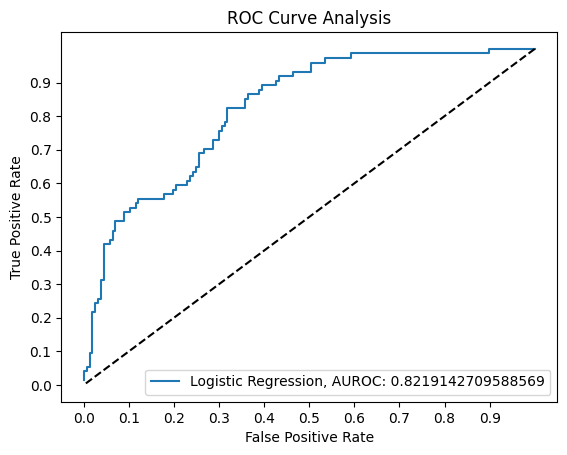

In [749]:
w, e = logisticRegression(X_train, y_train,step=3e-3, max_iter=10000)

y_predicted = predictLogisticRegression(X_test, w)
#print(y_predicted)

fpr_lr, npr_lr = get_fpr_tpr(y_predicted, list(y_test))

lr_auroc = roc_auc_score(y_test, pd.DataFrame(y_predicted).get(1)) 
print("The AUROC for the Logistic Regression classifier is: {}".format(lr_auroc))

plt.plot(fpr_lr, npr_lr, label=f'Logistic Regression, AUROC: {lr_auroc}')
plt.plot(fpr_lr, fpr_lr,'--', color='black')
plt.title("ROC Curve Analysis")

# X-Ticks and X-label
plt.xticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')

# Y-Ticks and Y-label
plt.yticks(np.arange(0, 1, 0.1))
plt.ylabel('True Positive Rate')

# Legend
plt.legend()

plt.show()


# Part IV - Logistic Regression for multi-class classification

## Exercise 1 - Load the dataset
* Load the famous Iris dataset (using sklearn as shown below)
* Load the data in a matrix $X$ and the target in a vector $y$.
* Make a 70/30% train test partition of the dataset

In [750]:
from sklearn.datasets import load_iris

In [751]:
iris = load_iris()

Prepare $X$ and $y$

In [752]:
X = iris.data
y = iris.target


Split the data

In [753]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

## Exercise 2 - Train the Logistic Regression model
Train your LogisticRegression multi-class classifier using the sklearn implementation. 
* To use the cross entropy loss function and softmax activation function, the `multi_class` parameter needs to be set to "multinomial"

In [754]:
from sklearn.linear_model import LogisticRegression

In [755]:
# Let's create an instance of the LogisticRegression classifier for multiclass classification
lr_iris = LogisticRegression(multi_class='multinomial',solver='newton-cg')

Fit the data

In [756]:
# your code goes here: 
lr_iris.fit(X_train, y_train)


c:\Users\Matheus Pinto\Documents\fgv\3o_periodo\tecnicas_de_algoritmos_em_ciencia_de_dados\labs\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', solver='newton-cg')

## Exercise 3 - Make predictions and evaluate the model
Use the `predict_proba()` method to obtain the output of the predictions for the testing set. The values are the output of the softmax activation function. 
* Remember that the highest value of each prediction corresponds to the actual predicted class.
* Write a function `get_predicted_class()` that transforms the vector of softmax outputs (obtained from `predict_proba()`) to a vector that just contains the predicted class. 
    - This function takes as input a matrix $\hat{Y}_{proba} \in \mathbb{R}^{m\times k}$ where $m$ is the number of samples in the testing set and $k$ is the number of classes.

As an example: if the softmax output is as follows: `Y_pred_sm = [[0.1,0.2,0.7], [0.4,0.3,0.3]]`, then `get_predicted_class(Y_pred_sm)` should return: `[2,0]` as the highest value for the 1st prediction is class 2 and for the 2nd prediction is class 0.

In [757]:
# complete the input argument for the function to obtain the predictions for the testing set.
y_pred_sm = lr_iris.predict_proba(X_test)
        

In [758]:
def get_predicted_class(Y_proba):
    y_pred = np.zeros(Y_proba.shape[0])
    for index, line in enumerate(Y_proba):
        y_pred[index] = np.argmax(line)

    return y_pred

y_pred = get_predicted_class(y_pred_sm)
    

Now calculate the accuracy in the testing set using `y_pred`

In [759]:
def accuracy_lr(y_predicted, y):
    cp = 0 # Correct preditions
    ip = 0 # Incorrect predictions

    for index, prediction in enumerate(y_predicted):
        if prediction == y[index]:
            cp += 1
        else:
            ip += 1

    acuracy = cp / (cp + ip)
    return acuracy

print(f"Logistic Regression Iris Accuracy: {accuracy_lr(y_pred, y_test)}")

Logistic Regression Iris Accuracy: 1.0
